In [70]:
import os
os.chdir('/home/ubuntu/nndl-project/')

import open3d as o3d
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.dataset import load_voxel_grid # voxelization function

# 1) Preprocessing the ModelNet datasets

Both the <a href='https://lmb.informatik.uni-freiburg.de/resources/datasets/ORION/modelnet40_manually_aligned.tar'>ModelNet40 (manually aligned)</a> and the <a href='http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip'>ModelNet10</a> databases come organized in folders like:

```
├── _label
    ├── _train
    |   ├── label_001.off
    |       ...
    └── _train
        └── label_101.off
            ...
    ...
```

Since our voxelization algorithm relies on `PyVista`, we cannot load directly `.off` files as meshes. We will need to convert them in the correct format with the help of another library, `Open3D`. 

In [3]:
# define modelnet directory
dataset_dir = '/home/ubuntu/nndl-project/data/modelnet10/'

# first, let's move all current models in a subdirectory off/

!mkdir -p /home/ubuntu/nndl-project/data/modelnet10/off
# !mv /home/ubuntu/nndl-project/data/modelnet10/* /home/ubuntu/nndl-project/data/modelnet10/off/

In [18]:
# then we walk 
ROOT = dataset_dir+'off/'

!mkdir -p /home/ubuntu/nndl-project/data/modelnet10/ply



pbar = tqdm.tqdm(list(os.walk(ROOT)))

for path,subdirs,files in pbar:
    for f in files:
        if f[-4:] != '.off': continue # skip non .off files
        
        filename,extension = f.split('.')
        destination_path = path.replace("/off/", "/ply/")+'/{}.ply'.format(filename)
        if not os.path.exists(path.replace("/off/", "/ply/")): os.makedirs(path.replace("/off/", "/ply/"))
        
        mesh = o3d.io.read_triangle_mesh(path+'/'+f)
        o3d.io.write_triangle_mesh(destination_path, mesh)

100%|██████████| 31/31 [02:29<00:00,  4.83s/it]


Now, let's check the content of our newly creater `ply/` directory:

In [19]:
!ls /home/ubuntu/nndl-project/data/modelnet10/ply

bathtub  bed  chair  desk  dresser  monitor  night_stand  sofa	table  toilet


In [20]:
!ls /home/ubuntu/nndl-project/data/modelnet10/ply/bathtub/test

bathtub_0107.ply  bathtub_0120.ply  bathtub_0133.ply  bathtub_0146.ply
bathtub_0108.ply  bathtub_0121.ply  bathtub_0134.ply  bathtub_0147.ply
bathtub_0109.ply  bathtub_0122.ply  bathtub_0135.ply  bathtub_0148.ply
bathtub_0110.ply  bathtub_0123.ply  bathtub_0136.ply  bathtub_0149.ply
bathtub_0111.ply  bathtub_0124.ply  bathtub_0137.ply  bathtub_0150.ply
bathtub_0112.ply  bathtub_0125.ply  bathtub_0138.ply  bathtub_0151.ply
bathtub_0113.ply  bathtub_0126.ply  bathtub_0139.ply  bathtub_0152.ply
bathtub_0114.ply  bathtub_0127.ply  bathtub_0140.ply  bathtub_0153.ply
bathtub_0115.ply  bathtub_0128.ply  bathtub_0141.ply  bathtub_0154.ply
bathtub_0116.ply  bathtub_0129.ply  bathtub_0142.ply  bathtub_0155.ply
bathtub_0117.ply  bathtub_0130.ply  bathtub_0143.ply  bathtub_0156.ply
bathtub_0118.ply  bathtub_0131.ply  bathtub_0144.ply
bathtub_0119.ply  bathtub_0132.ply  bathtub_0145.ply


# 2) Preprocessing the voxel grid based on orientation class

## The `orientation_classes` table

When we want to train our model on multiple orientation, we can do so by defining a discrete set of orientation each object can occur in; we call these _orientation classes_, and our dataset of possible voxel grids input will be $\sum_k N_k O_k$ where $k$ runs on the number of object labels; we call these _classes_.

To speed up training in this case, we want to pre-compute the voxel grids and store them in `.npy` numpy files. So first, let's create the subdirectory:

In [21]:
!mkdir -p /home/ubuntu/nndl-project/data/modelnet10/npy/

Now, to define the orientation classes, we will use a `pandas.DataFrame`; we can custom define it later to tune our model and load it in our script, but for now we will go with a simple 4 classes for each object, each corresponding to a rotation of $90°$ around the $z$ axis.

We want the table to define each orientation class, link it with its associated class, a global index, and the $x,y,z$ rotation components in degrees.

In [71]:
# grab the labels from the other folder
labels = !ls /home/ubuntu/nndl-project/data/modelnet10/ply

# 4 orientation classes per label
class_id = [list(range(4)) for label in labels]

# create dataframe
orientation_classes = pd.DataFrame({
    'label' : labels,
    'class_id' : class_id
}).explode('class_id',ignore_index=True)

# now we have the index, the label, and the index of the orientation class relative to its parent class
orientation_classes.head(10)

,label,class_id
0,bathtub,0
1,bathtub,1
2,bathtub,2
3,bathtub,3
4,bed,0
5,bed,1
6,bed,2
7,bed,3
8,chair,0
9,chair,1


In [72]:
# we use that to compute the rotation columns
orientation_classes['rot_x']=0
orientation_classes['rot_y']=0
orientation_classes['rot_z']=90*orientation_classes['class_id']

orientation_classes.head(10)

,label,class_id,rot_x,rot_y,rot_z
0,bathtub,0,0,0,0
1,bathtub,1,0,0,90
2,bathtub,2,0,0,180
3,bathtub,3,0,0,270
4,bed,0,0,0,0
5,bed,1,0,0,90
6,bed,2,0,0,180
7,bed,3,0,0,270
8,chair,0,0,0,0
9,chair,1,0,0,90


In [73]:
# save this table, use it with script later
orientation_classes.to_csv('/home/ubuntu/nndl-project/utils/orientation_classes.csv')

## The voxelization

Now, we walk through all the `.ply` files, and use the orientation classes table as a reference to generate voxel grids. The following code takes quite a while to complete the voxelization, so we will run the script overnight, but here is its working:

In [70]:
# long, do not execute! will run the script separately overnight
if False:

    N=30

    ply_root = '/home/ubuntu/nndl-project/data/modelnet10/ply/'


    pbar = tqdm.tqdm(list(os.walk(ply_root)))

    for root,subdirs,files in pbar:
        for f in files:
            if f[-4:] != '.ply' : continue
            
            label = root.split('/')[-2]
            destination_root = root.replace("/ply/", "/npy/")

            for index,row in orientation_classes[orientation_classes['label']==label].iterrows():

                pbar.set_description("Processing {}, orientation class {}".format(f,row['class_id']))

                # make dir for orientation class
                destination_path = os.path.join(destination_root,str(row['class_id']))
                if not os.path.exists(destination_path): os.makedirs(destination_path)

                # grab rotations
                rot_xyz = row[['rot_x','rot_y','rot_z']].values

                # voxelize
                array=load_voxel_grid(
                    os.path.join(root,f), # path of the original ply mesh
                    N,                    # resolution
                    *rot_xyz,             # rotation applied before voxelization
                    add_channel_dim=True)
                
                # save array
                file_destination_path = os.path.join(destination_path,f.split('.')[0]+'.npy')
                np.save(file_destination_path,array)
            


# 3) Generate metadata table

When we have the `.npy` files as well, we are now able to generate a metadata file that will be used by the `DataLoader` class to access these files.
The table will contain the following fields:

| path | split | label | label_id | orientation_class | orientation_class_id | rot_x | rot_y | rot_z |
|------|-------|-------|----------|-------------------|----------------------|-------|-------|-------|

We will list both the `.ply` files, that will have no orientation class predefined, and the `.npy` files, with their corresponding orientation class and rotation.

In [74]:
# first create a quick lookup table for the labels, from the orientation_classes table

lookup_table = pd.DataFrame({
    'label': labels,
    'label_id' : range(len(labels))}).set_index('label')

lookup_table

,label_id
label,
bathtub,0
bed,1
chair,2
desk,3
dresser,4
monitor,5
night_stand,6
sofa,7
table,8


In [75]:
# then we create the list of fields to populate
path = []
split = []
label = []
label_id = []
orientation_class = []
orientation_class_id = []
rot_x = []
rot_y = []
rot_z = []


for root,subdir,files in os.walk(dataset_dir):
    for f in files:

        # add entries for .ply files
        if f[-4:] == '.ply':
            
            path.append(os.path.join(root,f))
            split.append(root.split('/')[-1])
            label.append(root.split('/')[-2])
            label_id.append(lookup_table.loc[root.split('/')[-2]].item())
            # no orientation info
            orientation_class.append(None)
            orientation_class_id.append(None)
            rot_x.append(None)
            rot_y.append(None)
            rot_z.append(None)

        # add entries for .npy files
        elif f[-4:] == '.npy':
            
            path.append(os.path.join(root,f))
            # in this case we add the orientation class subdir
            split.append(root.split('/')[-2])
            label.append(root.split('/')[-3]) 
            label_id.append(lookup_table.loc[label[-1]].item())

            # orientation class is the id relative to the class: 0,1,2,3...n_orientation_classes_for_label
            orientation_class.append(int(root.split('/')[-1]))
            # orientation class id is the global index wrt the total number of orientation classes
            orientation_entry = orientation_classes[(orientation_classes['label']==label[-1]) * (orientation_classes['class_id']==orientation_class[-1])]
            orientation_class_id.append(orientation_entry.index.item())
            rot_x.append(orientation_entry['rot_x'].item())
            rot_y.append(orientation_entry['rot_y'].item())
            rot_z.append(orientation_entry['rot_z'].item())

        # skip everything else
        else:
            continue

# create the dataframe

metadata = pd.DataFrame(
    {
        'path' : path,
        'split' : split,
        'label' : label,
        'label_id' : label_id,
        'orientation_class' : orientation_class,
        'orientation_class_id' : orientation_class_id,
        'rot_x' : rot_x,
        'rot_y' : rot_y, 
        'rot_z' : rot_z
    }
).astype( # cast as types
    {
        'path' : 'str',
        'split' : 'str',
        'label' : 'str',
        'label_id' : 'Int32',
        'orientation_class' : 'Int32',
        'orientation_class_id' : 'Int32',
        'rot_x' : 'float',
        'rot_y' : 'float', 
        'rot_z' : 'float'
    }
)

In [34]:
# save it to disk
metadata.to_parquet(os.path.join(dataset_dir,'metadata.parquet')) # parquet is faster and preserves the index and dtypes

# take a look at the resulting table
metadata

,path,split,label,label_id,orientation_class,orientation_class_id,rot_x,rot_y,rot_z
0,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
1,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
2,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
3,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
4,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
...,...,...,...,...,...,...,...,...,...
24490,/home/ubuntu/nndl-project/data/modelnet10/ply/...,train,monitor,5,<NA>,<NA>,NaN,NaN,NaN
24491,/home/ubuntu/nndl-project/data/modelnet10/ply/...,train,monitor,5,<NA>,<NA>,NaN,NaN,NaN
24492,/home/ubuntu/nndl-project/data/modelnet10/ply/...,train,monitor,5,<NA>,<NA>,NaN,NaN,NaN
24493,/home/ubuntu/nndl-project/data/modelnet10/ply/...,train,monitor,5,<NA>,<NA>,NaN,NaN,NaN


Now we can perform all sorts of filtering and subsetting, which will be useful when defining the `DataSet` class. For example, when instructed to work with `.npy` files, its internal reference will be the subset:

In [35]:
# load it
metadata = pd.read_parquet(os.path.join(dataset_dir,'metadata.parquet')) 

# subset on the npy files
metadata[metadata['path'].str.contains('/npy/')]

,path,split,label,label_id,orientation_class,orientation_class_id,rot_x,rot_y,rot_z
0,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
1,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
2,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
3,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
4,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
...,...,...,...,...,...,...,...,...,...
19591,/home/ubuntu/nndl-project/data/modelnet10/npy/...,train,monitor,5,0,20,0.0,0.0,0.0
19592,/home/ubuntu/nndl-project/data/modelnet10/npy/...,train,monitor,5,0,20,0.0,0.0,0.0
19593,/home/ubuntu/nndl-project/data/modelnet10/npy/...,train,monitor,5,0,20,0.0,0.0,0.0
19594,/home/ubuntu/nndl-project/data/modelnet10/npy/...,train,monitor,5,0,20,0.0,0.0,0.0


In [76]:
# subset on npy files and split 
metadata[metadata['path'].str.contains('/npy/') * (metadata['split']=='test')]

,path,split,label,label_id,orientation_class,orientation_class_id,rot_x,rot_y,rot_z
0,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
1,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
2,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
3,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
4,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,desk,3,3,15,0.0,0.0,270.0
...,...,...,...,...,...,...,...,...,...
17731,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,monitor,5,0,20,0.0,0.0,0.0
17732,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,monitor,5,0,20,0.0,0.0,0.0
17733,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,monitor,5,0,20,0.0,0.0,0.0
17734,/home/ubuntu/nndl-project/data/modelnet10/npy/...,test,monitor,5,0,20,0.0,0.0,0.0


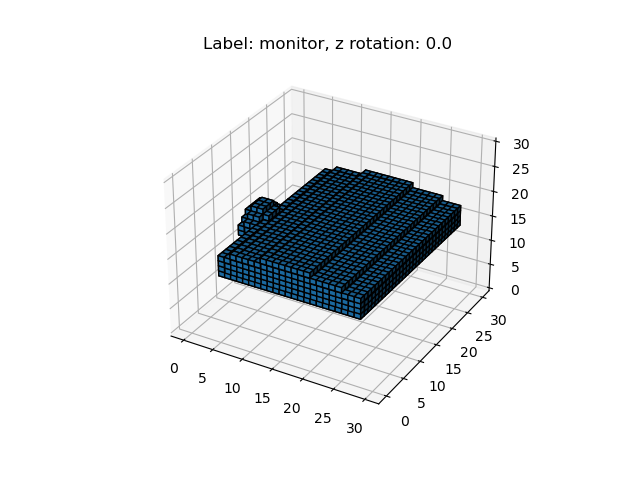

In [77]:
# load a sample and plot it

sample = metadata[metadata['path'].str.contains('/npy/')].sample(1)

%matplotlib Widget

vox_grid = np.load(sample['path'].item())

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(vox_grid[0], edgecolor='k') # subset on channel dimension
ax.set_title('Label: {}, z rotation: {}'.format(sample['label'].item(),sample['rot_z'].item()))

plt.show()